# Cursos de Series de tiempo con *Machine Learning*
## Modulo 53.2. Modelo de Machine Learning Pipeline con Databricks 
                        Elaborado por: Naren Castellon

<center><img src="https://miro.medium.com/v2/resize:fit:1400/0*U3oCoQqC-oi6vEKe" width="900" height="500"></center>

<a class="anchor" id="0.1"></a>



1.  [Introduction](#1)
2.  [Loading libraries and Data](#3)
3.  [Explore Data with the plot method](#3)
4.  [Training A Multivariate Time Series Model With MLForecast](#4)
5.  [Feature importances](#5)
6.  [Evaluate the model’s performance](#6)
7.  [Evaluate the model](#7)
8.  [References](#8)

# **Introduction** <a class="anchor" id="1"></a>

[Table of Contents](#0)

Un pipeline en el contexto del aprendizaje automático, se refiere a una secuencia de pasos organizados de manera estructurada para procesar y transformar datos antes de entrenar un modelo y hacer predicciones. El objetivo principal de un pipeline es automatizar y estandarizar el flujo de trabajo, lo que facilita la reproducibilidad y la implementación de modelos en producción.

Un proceso típico de aprendizaje automático consta de las siguientes etapas:

1. **Preprocesamiento de datos**: En esta etapa, se realizan varias tareas para preparar los datos antes de entrenar el modelo. Esto puede incluir limpieza de datos, manejo de valores faltantes, normalización o estandarización de variables, codificación de variables categóricas, selección de características relevantes, entre otros.

2. **División de datos**: es común dividir los datos en conjuntos de entrenamiento, validación y prueba. El conjunto de entrenamiento se usa para entrenar el modelo, el conjunto de validación se usa para ajustar los hiperparámetros y evaluar el rendimiento durante el ajuste del modelo, y el conjunto de prueba se usa para evaluar el rendimiento final del modelo.

3. **Entrenamiento del modelo**: en esta etapa, el modelo de aprendizaje automático se selecciona y se entrena utilizando los datos de entrenamiento. Esto implica ajustar los parámetros del modelo en función de los datos de entrenamiento para minimizar la función de pérdida o maximizar la métrica de rendimiento objetivo.

4. **Validación del modelo**: después de entrenar el modelo, su rendimiento se evalúa utilizando los datos de validación. Esto permite ajustar los hiperparámetros del modelo y realizar comparaciones entre diferentes configuraciones o algoritmos.

5. **Evaluación del modelo**: una vez que se han ajustado los hiperparámetros y se ha seleccionado el mejor modelo, se evalúa su rendimiento final utilizando el conjunto de prueba. Esto proporciona una estimación imparcial del rendimiento del modelo en datos invisibles.

6. **Predicciones**: Finalmente, el modelo entrenado se utiliza para realizar predicciones sobre datos nuevos o datos en tiempo real.

El uso de una canalización en el aprendizaje automático tiene varios beneficios, como la automatización de tareas repetitivas, la estandarización del flujo de trabajo, la facilidad de reproducir resultados y la capacidad de escalar y aplicar el modelo en producción de manera eficiente.

Es importante tener en cuenta que los pasos específicos y el orden de una tubería pueden variar según el problema y los requisitos del proyecto. Además, se pueden incluir etapas adicionales, como seleccionar el mejor modelo u optimizar hiperparámetros.

# **Cargamos las librerias** <a class="anchor" id="2"></a>

[Table of Contents](#0)

In [ ]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import datetime as dt
import time
from datetime import datetime, timedelta

# 
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose 

In [ ]:
# Models Sklearn
# ==============================================================================
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Mlforecast
# ==============================================================================
from mlforecast import MLForecast
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean
from mlforecast.target_transforms import Differences

from mlforecast.utils import PredictionIntervals
from mlforecast.utils import generate_daily_series, generate_prices_for_series
from utilsforecast.plotting import plot_series

In [ ]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5

# Define the plot size
# ==============================================================================

plt.rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

## **Cargamos los datos**

Utilizaremos datos del [conjunto de datos de tráfico del sitio web de la ciudad de Los Ángeles] (https://www.kaggle.com/datasets/cityofLA/lacity.org-website-traffic) en Kaggle.

Este conjunto de datos contiene el número de sesiones de usuarios del sitio web de la ciudad de Los Ángeles para cada día de 2014 a 2019.

Las sesiones son períodos de tiempo en los que un usuario está activo en un sitio web.

In [ ]:
# File location and type
file_location = "/FileStore/tables/lacity.org-website-traffic.csv/lacity_org_website_traffic.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "True"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
datos = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(datos)

Date,Device Category,Browser,# of Visitors,Sessions,Bounce Rate
2014-01-01T00:00:00.000,desktop,Chrome,900,934,55.5675
2014-01-01T00:00:00.000,desktop,Firefox,692,761,40.8673
2014-01-01T00:00:00.000,desktop,Internet Explorer,1038,1107,31.2556
2014-01-01T00:00:00.000,desktop,Opera,35,35,100
2014-01-01T00:00:00.000,desktop,Safari,484,554,24.9097
2014-01-01T00:00:00.000,mobile,Android Browser,242,311,89.0675
2014-01-01T00:00:00.000,mobile,Chrome,242,242,71.4876
2014-01-01T00:00:00.000,mobile,Internet Explorer,35,35,100
2014-01-01T00:00:00.000,mobile,Safari,969,1038,60.0193
2014-01-01T00:00:00.000,mobile,Safari (in-app),35,35,100


In [ ]:
# pasando a pandas
df = datos.toPandas()
df.head()

,Date,Device Category,Browser,# of Visitors,Sessions,Bounce Rate
0,2014-01-01T00:00:00.000,desktop,Chrome,900,934,55.5675
1,2014-01-01T00:00:00.000,desktop,Firefox,692,761,40.8673
2,2014-01-01T00:00:00.000,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01T00:00:00.000,desktop,Opera,35,35,100
4,2014-01-01T00:00:00.000,desktop,Safari,484,554,24.9097


In [ ]:
df.columns = [k.lower().replace(' ', '_').replace('#', 'qnty') for k in df.columns]
df['date'] = pd.to_datetime(df.date).dt.normalize()
df

,date,device_category,browser,qnty_of_visitors,sessions,bounce_rate
0,2014-01-01,desktop,Chrome,900,934,55.5675
1,2014-01-01,desktop,Firefox,692,761,40.8673
2,2014-01-01,desktop,Internet Explorer,1038,1107,31.2556
3,2014-01-01,desktop,Opera,35,35,100
4,2014-01-01,desktop,Safari,484,554,24.9097
...,...,...,...,...,...,...
8348980,2019-08-27,mobile,Chrome,199,318,50
8348981,2019-08-27,mobile,Firefox,40,40,100
8348982,2019-08-27,mobile,Safari,199,199,79.8995
8348983,2019-08-27,tablet,Amazon Silk,40,40,100


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8348985 entries, 0 to 8348984
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   device_category   object        
 2   browser           object        
 3   qnty_of_visitors  object        
 4   sessions          object        
 5   bounce_rate       object        
dtypes: datetime64[ns](1), object(5)
memory usage: 382.2+ MB


In [ ]:
# Convertir la columna 'Columna' a numérica
df['qnty_of_visitors'] = df['qnty_of_visitors'].astype(int)
df['sessions'] = df['sessions'].astype(int)
df['bounce_rate'] = df['bounce_rate'].astype(float)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
# Aggregate the data based on Date, Device and Session.
data = df[['date', 'device_category', 'sessions']].groupby(['date', 'device_category']).sum().reset_index()

# Fill Missing Any Date to 0
df_pivot = data.pivot(index='device_category', values=['sessions'], columns='date')
df_pivot.fillna(0, inplace=True)

df_pivot = df_pivot.stack().reset_index().sort_values(by=['date', 'device_category']).reset_index(drop=True)
df_pivot.columns = ['device', 'date', 'session']
data = df_pivot[['date', 'device', 'session']]

del df_pivot

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6195 entries, 0 to 6194
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     6195 non-null   datetime64[ns]
 1   device   6195 non-null   object        
 2   session  6195 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 145.3+ KB


The input to MlForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
data=data.rename(columns={"date": "ds","device":"unique_id", "session": "y"})
data.head()

,ds,unique_id,y
0,2014-01-01,desktop,616768.0
1,2014-01-01,mobile,287547.0
2,2014-01-01,tablet,15967.0
3,2014-01-02,desktop,2030513.0
4,2014-01-02,mobile,321557.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6195 entries, 0 to 6194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         6195 non-null   datetime64[ns]
 1   unique_id  6195 non-null   object        
 2   y          6195 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 145.3+ KB


# **Explore Data with the plot method** <a class="anchor" id="3"></a>

[Table of Contents](#0)

We are going to use the `plot_series` function to visualize our data.

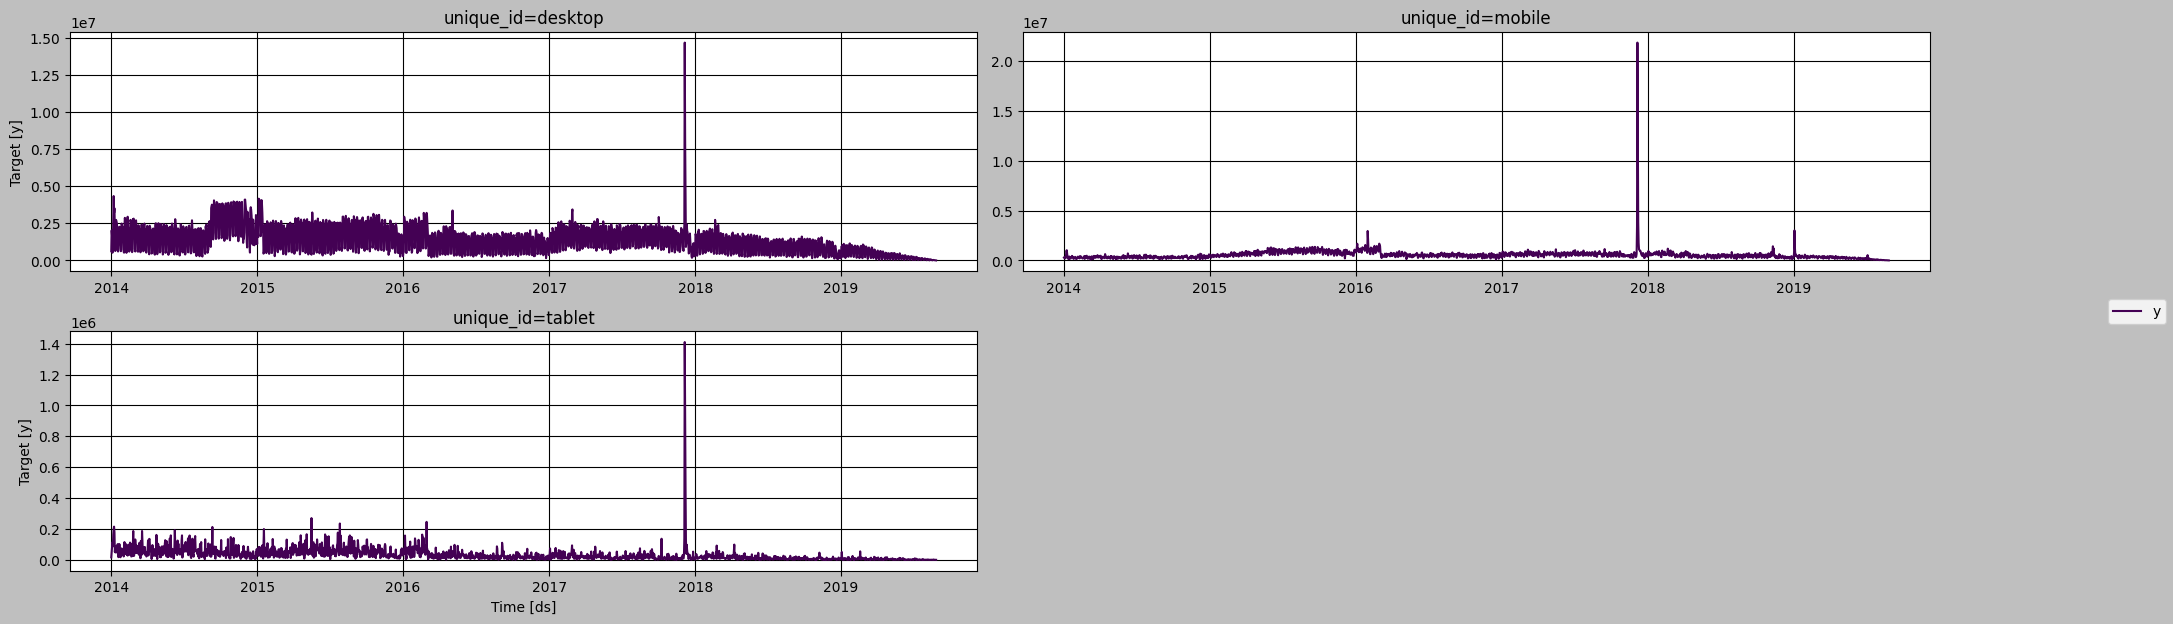

In [ ]:
plot_series(data)


## **The Augmented Dickey-Fuller Test**
An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

- Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
- Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

- ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
- ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

In [ ]:
def augmented_dickey_fuller_test(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
augmented_dickey_fuller_test(data["y"],"website-traffic")

Dickey-Fuller test results for columns: website-traffic


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Test Statistic                -7.269285e+00
p-value                        1.604152e-10
No Lags Used                   3.400000e+01
Number of observations used    6.160000e+03
Critical Value (1%)           -3.431412e+00
Critical Value (5%)           -2.862009e+00
Critical Value (10%)          -2.567020e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary



# **Split the data into training and testing** 


Dividamos nuestros datos en dos partes:

1. Datos para entrenar el modelo.
2. Datos para probar el modelo, aquí usaremos los últimos 30 días.


In [ ]:
train = data[data.ds<='2019-07-28'] 
test=data[(data['ds'] > '2019-07-28')]

test.drop("y",axis=1, inplace=True)
train.shape, test.shape

((6105, 3), (90, 2))

In [ ]:
train.head()

,ds,unique_id,y
0,2014-01-01,desktop,616768.0
1,2014-01-01,mobile,287547.0
2,2014-01-01,tablet,15967.0
3,2014-01-02,desktop,2030513.0
4,2014-01-02,mobile,321557.0


In [ ]:
test.head()

,ds,unique_id
6105,2019-07-29,desktop
6106,2019-07-29,mobile
6107,2019-07-29,tablet
6108,2019-07-30,desktop
6109,2019-07-30,mobile


# **Training A Multivariate Time Series Model With MLForecast**<a class="anchor" id="4"></a>

[Table of Contents](#0)

## **Building Model**

Veamos cómo podemos diseñar funciones y entrenar un `XGBoost` y un `RandomForest` con mlforecast.

En este caso vamos a crear un `Pipeline` con la función `make_pileline` en el cual vamos a usar el `SimpleImputer` en caso de que tengamos datos nulos, y también usaremos el `StandardScaler` para la estandarización del datos. Recordemos que el `StandarScaler` y el `SimpleImputer` se ejecutan en el método fit.

Hemos agregado la función `StandardScaler` a la construcción del modelo que vamos a usar, sin embargo podemos crear esta misma función y usarla en el parámetro `differences`, sin embargo para ejemplificar este tutorial vamos a utilice el `StandardScaler` de la construcción del `Pipeline`.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from mlforecast.target_transforms import LocalRobustScaler, LocalStandardScaler
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [ ]:
num_selector = make_column_selector(dtype_include=np.number)
num_selector

In [ ]:
num_linear_processor = make_pipeline(StandardScaler(),
                                     PowerTransformer(method = 'yeo-johnson'),
                                     SimpleImputer(strategy="mean", add_indicator=True))
num_linear_processor

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('powertransformer', PowerTransformer()),
                ('simpleimputer', SimpleImputer(add_indicator=True))])

In [ ]:
linear_preprocessor = make_column_transformer((num_linear_processor, num_selector))
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('powertransformer',
                                                  PowerTransformer()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6824c0b90>)])

In [ ]:
rf_pipe = make_pipeline(linear_preprocessor, RandomForestRegressor())
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6824c0b90>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
xgb_pipe = make_pipeline(linear_preprocessor, XGBRegressor())
xgb_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6824c0b90>)])),
                ('xgbregressor',
                 XGBRegressor(base_scor...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
#models = [XGBRegressor(random_state = 1463, n_estimators = 1000, max_depth = 5), rf_pipe]
models = [rf_pipe, xgb_pipe]
models

[Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline',
                                                   Pipeline(steps=[('standardscaler',
                                                                    StandardScaler()),
                                                                   ('powertransformer',
                                                                    PowerTransformer()),
                                                                   ('simpleimputer',
                                                                    SimpleImputer(add_indicator=True))]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fa6824c0b90>)])),
                 ('randomforestregressor', RandomForestRegressor())]),
 Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipeline',
                                            

In [ ]:
models_2 = [make_pipeline(SimpleImputer(strategy="mean", add_indicator=True), 
                        StandardScaler(),
                        PowerTransformer(method='yeo-johnson'),
                        RandomForestRegressor(random_state=0, n_estimators=100)),
                        
                        XGBRegressor(random_state=0, n_estimators=100)]
models_2

[Pipeline(steps=[('simpleimputer', SimpleImputer(add_indicator=True)),
                 ('standardscaler', StandardScaler()),
                 ('powertransformer', PowerTransformer()),
                 ('randomforestregressor',
                  RandomForestRegressor(random_state=0))]),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num

We fit the models by instantiating a new `MlForecast` object with the following parameters:

* `models:` a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `lags:` Lags of the target to uses as feature.

* `lag_transforms:` Mapping of target lags to their transformations.

* `date_features:` Features computed from the dates. Can be `pandas` date attributes or functions that will take the dates as input.

* `differences:` Differences to take of the target before computing the features. These are restored at the forecasting step.

* `num_threads:` Number of threads to use when computing the features.

* `target_transforms:` Transformations that will be applied to the target computing the features and restored after the forecasting step.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

The `lags` argument is a list of lags we want to use in our model. Lags are the number of steps in the past we want to use to predict the future.

So in our case, we are using the value of the target variable 1, 7, and 14 days before the timestamp date of the observation.

This is why it’s important to have all dates, even the ones with missing values and zeros in the datasets, so these features can be computed correctly.

We also pass the `lag_transforms` argument, which is a dictionary with the `lag` as the key and a list of functions as the value.

These functions will be applied to the lagged series. For example, we are applying a `rolling mean` with a window of 7 days to the lag 1.

This means that we will have a feature that is the mean of the 7 last values of the target variable after shifting it 1 day.

We are using the `window_ops` library which is optimized and recommended for MLForecast.

Each tuple in the list of transforms is a function and its arguments. For example, the `rolling_mean` function takes a window size as its argument.

The best value for the window size is specific for each time series, so we need to try different values and see which one works best.

The `date_features` argument is a list of date components we want to extract from the date column.

In [ ]:
train.head()

,ds,unique_id,y
0,2014-01-01,desktop,616768.0
1,2014-01-01,mobile,287547.0
2,2014-01-01,tablet,15967.0
3,2014-01-02,desktop,2030513.0
4,2014-01-02,mobile,321557.0


In [ ]:
mlf = MLForecast(models=models,
                   freq='D',
                   lags = range(1,14, 1),
                   date_features=['week', 'month','day'],
                   num_threads=6)

With the `preprocess` function we can observe all the transformation that has been made of the target variable before training the model.

In [ ]:
prep = mlf.preprocess(data)
prep.head()

,ds,unique_id,y,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,week,month,day
39,2014-01-14,desktop,2595781.0,2735596.0,693748.0,630165.0,1965612.0,3522842.0,3213820.0,4346042.0,2894615.0,837332.0,519847.0,1663159.0,2030513.0,616768.0,3,1,14
40,2014-01-14,mobile,391598.0,152021.0,289818.0,181345.0,305340.0,691006.0,1022962.0,923906.0,367005.0,234696.0,201648.0,334096.0,321557.0,287547.0,3,1,14
41,2014-01-14,tablet,88987.0,66240.0,47763.0,87655.0,49781.0,178610.0,214816.0,199893.0,164370.0,87354.0,114399.0,84173.0,54476.0,15967.0,3,1,14
42,2014-01-15,desktop,2489993.0,2595781.0,2735596.0,693748.0,630165.0,1965612.0,3522842.0,3213820.0,4346042.0,2894615.0,837332.0,519847.0,1663159.0,2030513.0,3,1,15
43,2014-01-15,mobile,158945.0,391598.0,152021.0,289818.0,181345.0,305340.0,691006.0,1022962.0,923906.0,367005.0,234696.0,201648.0,334096.0,321557.0,3,1,15


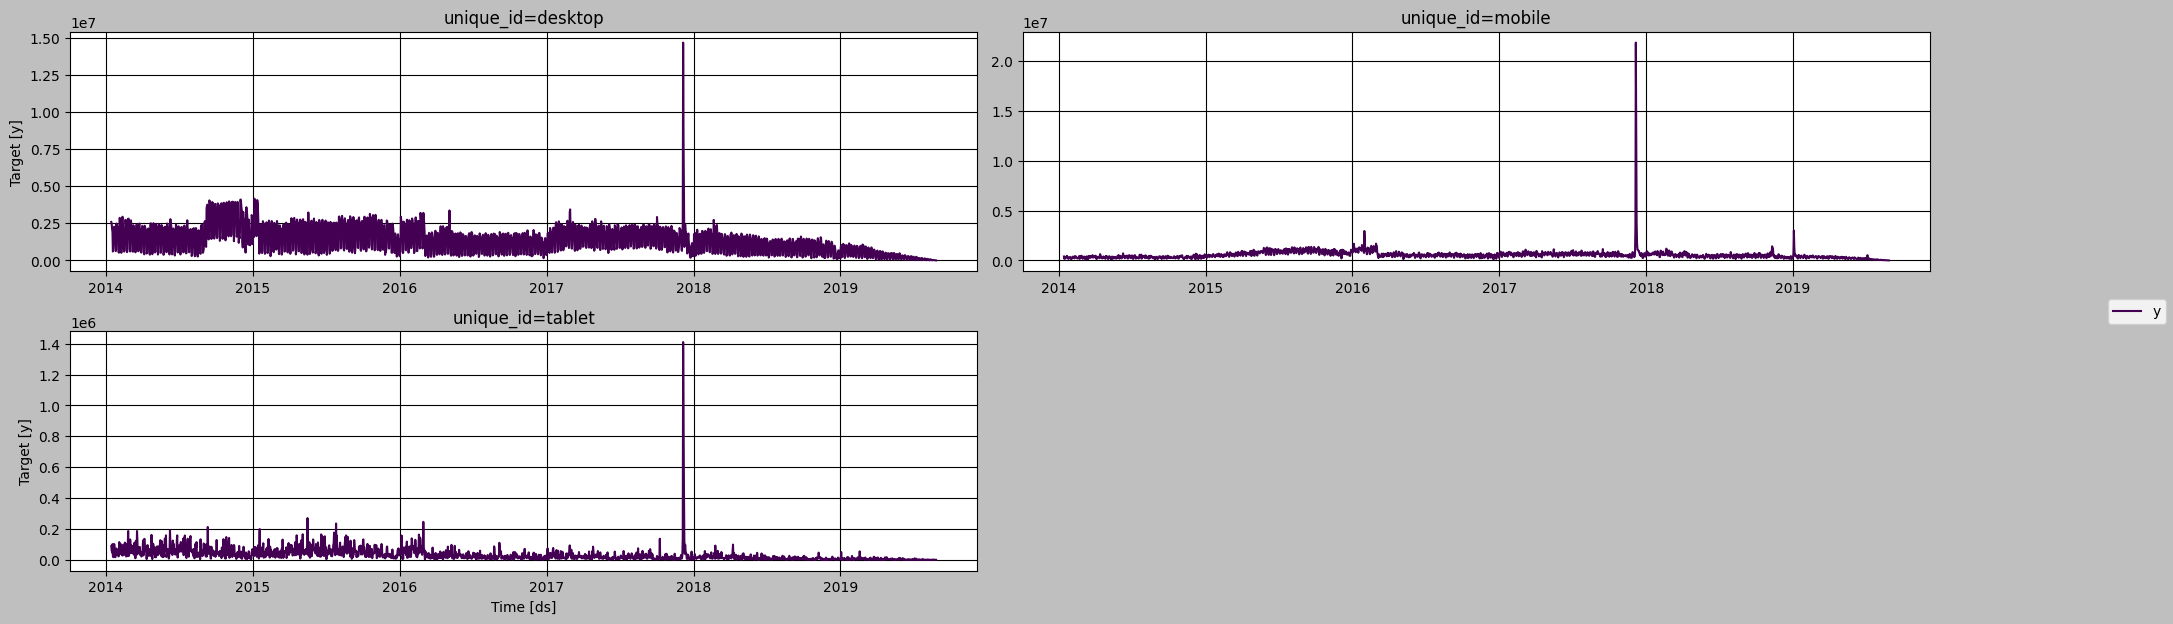

In [ ]:
plot_series(prep)


In [ ]:
prep.drop(columns=['unique_id', 'ds']).corr()['y']

y        1.000000
lag1     0.803102
lag2     0.603426
lag3     0.524784
lag4     0.518003
lag5     0.568750
lag6     0.699829
lag7     0.795037
lag8     0.696378
lag9     0.559107
lag10    0.502809
lag11    0.500928
lag12    0.549393
lag13    0.678674
week     0.016070
month    0.015280
day     -0.023366
Name: y, dtype: float64

Here we can observe the relationship that exists between each day of one of the variables, with this information we can use it to make a decision about what process (lags or lag_transforms) we can use, at the end of the training and predictions of the model we are going to visualize the characteristics more amounts, we will have a little more foundation to be able to add or eliminate those transformations that will be of greater importance for our model.

## **Fit method**

In [ ]:
mlf.fit(train,fitted=True, 
        prediction_intervals=PredictionIntervals(n_windows=3, h=30, method="conformal_distribution") )

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

MLForecast(models=[RandomForestRegressor, XGBRegressor], freq=D, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13'], date_features=['week', 'month', 'day'], num_threads=6)

## **Predict method with prediction intervals**

In [ ]:
forecast_df = mlf.predict(h = 30,level = [80,95])
forecast_df 

,unique_id,ds,RandomForestRegressor,XGBRegressor,RandomForestRegressor-lo-95,RandomForestRegressor-lo-80,RandomForestRegressor-hi-80,RandomForestRegressor-hi-95,XGBRegressor-lo-95,XGBRegressor-lo-80,XGBRegressor-hi-80,XGBRegressor-hi-95
0,desktop,2019-07-29,103056.72,63609.617188,24023.18500,50525.590,155587.850,182090.25500,-71062.886719,-24371.835938,151591.070312,198282.121094
1,desktop,2019-07-30,97345.63,68153.437500,-24390.65000,2355.640,192335.620,219081.91000,-73156.259766,-34435.335938,170742.210938,209463.134766
2,desktop,2019-07-31,89718.62,75042.289062,32896.74375,35437.455,143999.785,146540.49625,-79101.931641,-20805.609375,170890.187500,229186.509766
3,desktop,2019-08-01,78394.36,58693.359375,-18363.85750,-18228.820,175017.540,175152.57750,-102214.167969,-56913.875000,174300.593750,219600.886719
4,desktop,2019-08-02,59466.80,56871.257812,-40420.64125,-28203.565,147137.165,159354.24125,6384.878906,9639.304688,104103.210938,107357.636719
...,...,...,...,...,...,...,...,...,...,...,...,...
85,tablet,2019-08-23,6117.00,6682.645996,-8368.40125,-6741.835,18975.835,20602.40125,-1491.695190,398.883789,12966.408203,14856.987183
86,tablet,2019-08-24,5771.14,6682.645996,-9219.86750,-8766.500,20308.780,20762.14750,-1708.787598,-1423.485840,14788.777832,15074.079590
87,tablet,2019-08-25,7615.49,5398.141113,-7283.82250,-6999.880,22230.860,22514.80250,-3770.053711,-2507.711426,13303.993652,14566.335938
88,tablet,2019-08-26,6998.88,5398.141113,-8664.73250,-8616.410,22614.170,22662.49250,-4840.996582,-4832.219238,15628.501465,15637.278809


We can see the predictions for the Pipeline (Random Forest) and the XGBRegressor models.

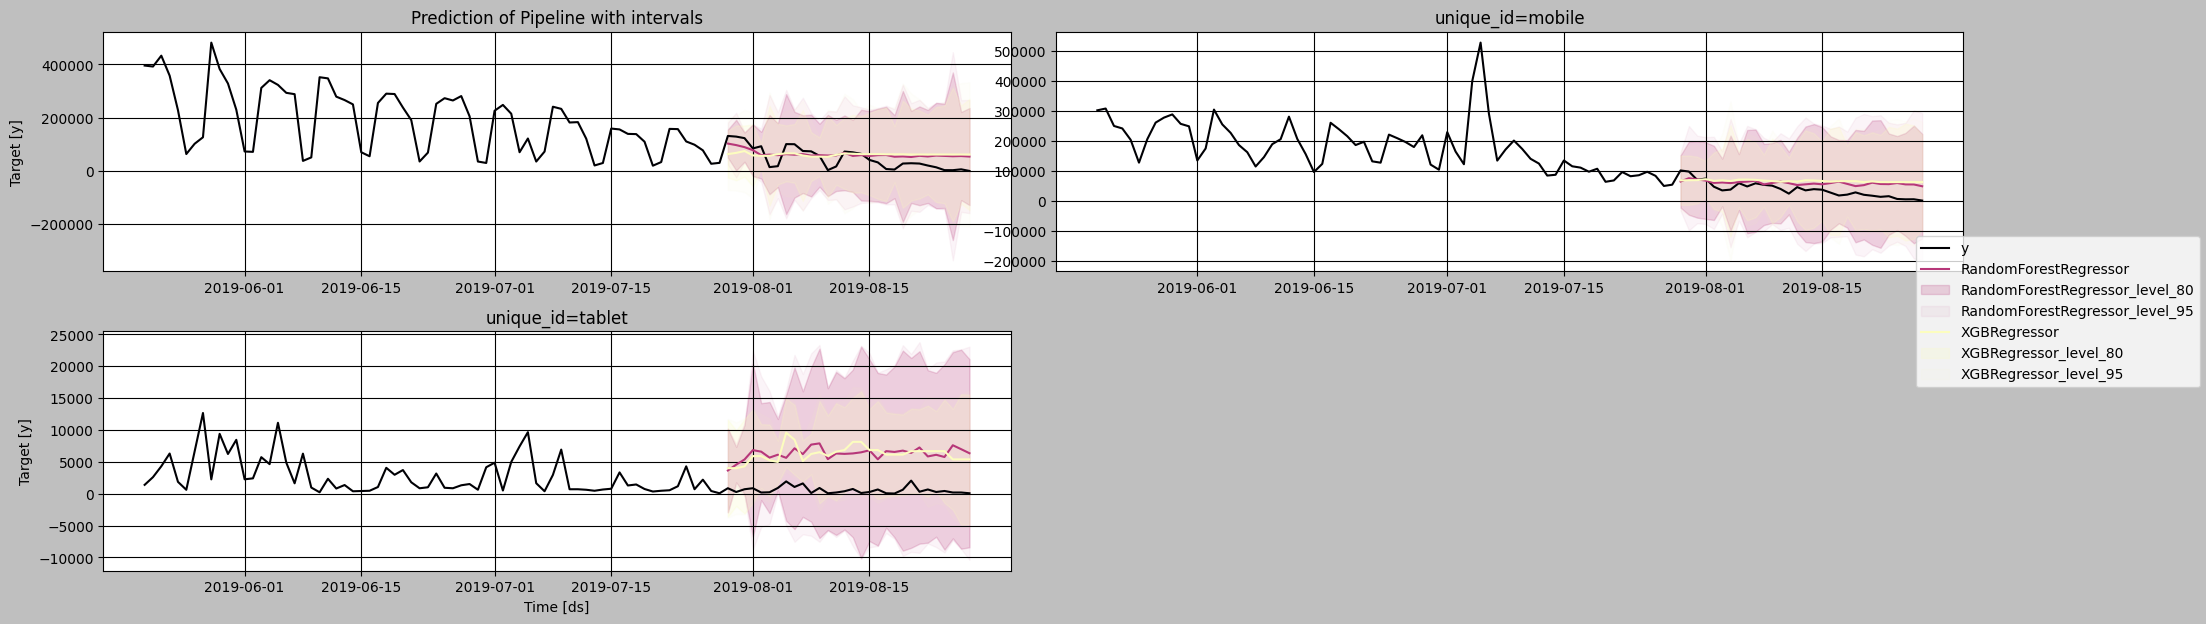

In [ ]:
fig=plot_series(data, forecast_df, level=[80,95], max_insample_length=100,engine="matplotlib", palette="magma")
fig.get_axes()[0].set_title("Prediction of Pipeline with intervals")
fig

# **Feature importances**

In [ ]:
fig=pd.Series(mlf.models_['XGBRegressor'].feature_importances_, 
          index=mlf.ts.features_order_).sort_values(ascending=False).plot.bar(title='Feature Importance XGBRegressor')
plt.grid(True)
#plt.savefig('../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_feature_importance.png',dpi=300)
plt.show()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-2122760237006779>, line 1
----> 1 fig=pd.Series(mlf.models_['XGBRegressor'].feature_importances_, 
      2           index=mlf.ts.features_order_).sort_values(ascending=False).plot.bar(title='Feature Importance XGBRegressor')
      3 plt.grid(True)
      4 #plt.savefig('../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_feature_importance.png',dpi=300)

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

![](../figs/pipeline_with_sklearn_and_xgboost_random_forest__plot_feature_importance.png)

# **Evaluate the model’s performance** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

## **Perform time series cross-validation**

In order to get an estimate of how well our model will be when predicting future data we can perform cross validation, which consist on training a few models independently on different subsets of the data, using them to predict a validation set and measuring their performance.

Since our data depends on time, we make our splits by removing the last portions of the series and using them as validation sets. This process is implemented in `MLForecast.cross_validation`.

Cross-validation of time series models is considered a best practice but most implementations are very slow. The `MlForecast` library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using `Ray, Dask or Spark`.

Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
cv_result = mlf.cross_validation(
    train,
    n_windows=5,  # number of models to train/splits to perform
    h =30,  # length of the validation set in each window
    prediction_intervals=PredictionIntervals(n_windows=5, h =30, method="conformal_distribution"),
)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` index. If you dont like working with index just run `crossvalidation_df.resetindex()`.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
cv_result

,unique_id,ds,cutoff,y,RandomForestRegressor,XGBRegressor
0,desktop,2019-03-01,2019-02-28,717781.0,773505.30,7.382636e+05
1,desktop,2019-03-02,2019-02-28,221107.0,275227.42,3.509771e+05
2,desktop,2019-03-03,2019-02-28,218189.0,288252.12,2.310197e+05
3,desktop,2019-03-04,2019-02-28,858754.0,1063846.97,9.834802e+05
4,desktop,2019-03-05,2019-02-28,941569.0,1117129.38,1.144393e+06
...,...,...,...,...,...,...
445,tablet,2019-07-24,2019-06-28,4305.0,3821.12,4.023989e+03
446,tablet,2019-07-25,2019-06-28,711.0,3875.41,5.843470e+03
447,tablet,2019-07-26,2019-06-28,2214.0,4032.72,5.843470e+03
448,tablet,2019-07-27,2019-06-28,435.0,3980.38,8.112821e+03


# **Evaluate the model** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

`pip install datasetsforecast`

In [ ]:
from datasetsforecast.losses import mse, mae, rmse, mape

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case,`Pipeline` and `XGBRegressor() Model`.

In [ ]:
from datasetsforecast.losses import mse, mae, rmse

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [ ]:
evaluation_df = evaluate_cross_validation(cv_result.set_index("unique_id"), rmse)

evaluation_df

,RandomForestRegressor,XGBRegressor,best_model
unique_id,,,
desktop,153358.249878,146355.911613,XGBRegressor
mobile,86530.450169,96263.014245,RandomForestRegressor
tablet,9747.426773,6215.120936,XGBRegressor


The result obtained in this case is given by each type of `unique_ide` identifying the model created with the `RMSE` metric, in which both results are compared.

In [ ]:
cv_rmse = cv_result.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'], df['XGBRegressor'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

In [ ]:
cv_rmse = cv_result.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'], df['Pipeline'])).mean()
print("RMSE using cross-validation: ", cv_rmse)

In the previous result, we obtain the `RMSE` metric in a general way without considering the `Unique_id` identifiers, only taking as reference the values obtained from the `Crossvalidation` result, in this case the `Pipeline` and the `XGBRegressor` model.

# **References** <a class="anchor" id="8"></a>

[Table of Contents](#0)


1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters for Mlforecast](https://nixtla.github.io/mlforecast/forecast.html).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).
8. [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html)